In [1]:
import pickle
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from pyts.classification import TimeSeriesForest
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [30]:
with open('train/precision_gridsearchcv/X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

freqs = list(X_test_df.keys())

In [14]:
def eval_test(X_test_df, forest_freq_clf_list, is_catboost=True):
    X_test_df = pd.DataFrame(X_test_df)
    y_pred = []
    for i in range(X_test_df.shape[0]):
        y_cur_pred = []
        for freq in freqs:
            cur_freq_X = X_test_df.iloc[i][freq]
            if is_catboost:
                cur_freq_X = [str(cur_elem) for cur_elem in cur_freq_X]
            cur_freq_y = forest_freq_clf_list[freq].predict([cur_freq_X])[0]
            y_cur_pred.append(cur_freq_y)
        pred_mode = stats.mode(np.array(y_cur_pred))[0]
        y_pred.append(pred_mode)
    return y_pred


def get_data_stats(train, test):
    print("(train) АКР:", train.count(1))
    print("(train) не АКР:", train.count(0))

    print("(test) АКР:", test.count(1))
    print("(test) не АКР:", test.count(0))


def build_conf_matrix(labels, predict, class_name):
    lab, pred = [], []
    for i in range(len(labels)):
        if predict[i] == class_name:
            pred.append(0)
        else:
            pred.append(1)
        if labels[i] == class_name:
            lab.append(0)
        else:
            lab.append(1)
    return confusion_matrix(lab, pred, normalize='true')


def eval_metrics(y_pred, y_test, id=""):
    print("f1_score: ", f1_score(y_test, y_pred))
    print("precision_score: ", precision_score(y_test, y_pred))
    print("recall_score: ", recall_score(y_test, y_pred))

    get_res = {0: "нет АКР", 1: "АКР"}

    for i in range(2):
        heatmap = sns.heatmap(build_conf_matrix(y_test, y_pred, i), annot=True, cmap='YlGnBu')
        heatmap.set_title(get_res[i], fontdict={'fontsize':14}, pad=10)
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.savefig(f"Класс {i} ({id}).png", dpi=300)
        plt.show()


def cleared_test_ds(X_dict, y, threshold=1):
    """
        Функция, которая удаляет из тренировочной выборки последовательности, в
        которых значение напряжения равно нулю больше чем threshold секунд 
    """
    new_X_dict = {}
    bad_idx = []
    # находим для каждой частоты индексы с данными, в которых больше одного 0
    freqs = list(X_dict.keys())
    for freq in freqs:
        cur_freq_test = X_dict[freq]
        for i in range(len(cur_freq_test)):
            if cur_freq_test[i].count(0) > threshold:
                bad_idx.append(i)
    bad_idx = np.unique(np.array(bad_idx)).tolist()
    new_y = pd.DataFrame(y).drop(bad_idx, axis=0).values.tolist()
    new_y = [y[0] for y in new_y]
    # удаляем для каждой частоты объекты с этими индексами (в т.ч. в 'y')
    for freq in freqs:
        cur_freq_test = X_dict[freq]
        new_X = pd.DataFrame(cur_freq_test).drop(bad_idx, axis=0).values.tolist()
        new_X_dict[freq] = new_X
    return new_X_dict, new_y

## Обучил на GridSearchCV, с приоритетом на Precision

обучалось 220 мин.

    param_grid = {
        'iterations': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 1],
        'depth': [4, 6, 8]
    }

In [23]:
with open('train/precision_gridsearchcv/X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

with open('train/precision_gridsearchcv/freq_clf_list.pkl', 'rb') as file:
    freq_clf_list = pickle.load(file)

with open('train/precision_gridsearchcv/y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('train/precision_gridsearchcv/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)



In [24]:
get_data_stats(y_train, y_test)

(train) АКР: 26
(train) не АКР: 22
(test) АКР: 5
(test) не АКР: 7


In [25]:
new_X_test_df, new_y_test = cleared_test_ds(X_test_df, y_test)

In [26]:
y_pred = eval_test(new_X_test_df, freq_clf_list)

In [27]:
confusion_matrix(y_test, y_pred, normalize='true')

array([[0., 1.],
       [0., 1.]])

f1_score:  0.5882352941176471
precision_score:  0.4166666666666667
recall_score:  1.0


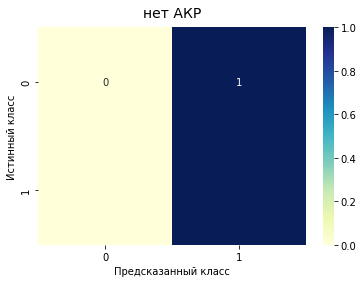

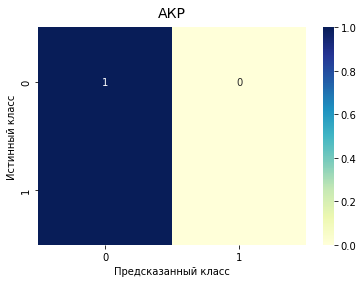

In [28]:
eval_metrics(y_pred, y_test)

## Обучил на GridSearchCV, с приоритетом на Accuracy

обучалось 210 мин.

In [33]:
with open('train/accuracy_gridsearchcv/X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

with open('train/accuracy_gridsearchcv/freq_clf_list.pkl', 'rb') as file:
    freq_clf_list = pickle.load(file)

with open('train/accuracy_gridsearchcv/y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('train/accuracy_gridsearchcv/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


In [34]:
get_data_stats(y_train, y_test)

(train) АКР: 26
(train) не АКР: 22
(test) АКР: 5
(test) не АКР: 7


In [35]:
new_X_test_df, new_y_test = cleared_test_ds(X_test_df, y_test)

In [36]:
y_pred = eval_test(new_X_test_df, freq_clf_list)

In [37]:
confusion_matrix(y_test, y_pred, normalize='true')

array([[0., 1.],
       [0., 1.]])

f1_score:  0.5882352941176471
precision_score:  0.4166666666666667
recall_score:  1.0


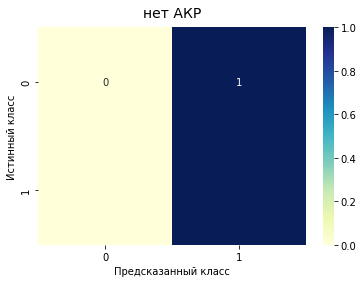

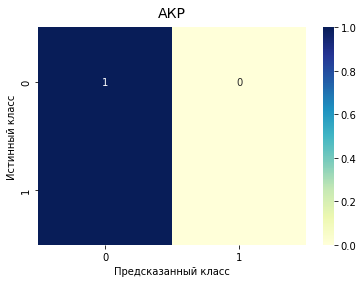

In [38]:
eval_metrics(y_pred, y_test)

## Обучил на RandomSearchCV, с приоритетом на Precision

In [39]:
with open('train/precision_randomsearchcv/X_test_df.pkl', 'rb') as file:
    X_test_df = pickle.load(file)

with open('train/precision_randomsearchcv/freq_clf_list.pkl', 'rb') as file:
    freq_clf_list = pickle.load(file)

with open('train/precision_randomsearchcv/y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('train/precision_randomsearchcv/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


In [40]:
get_data_stats(y_train, y_test)

(train) АКР: 26
(train) не АКР: 22
(test) АКР: 5
(test) не АКР: 7


In [41]:
new_X_test_df, new_y_test = cleared_test_ds(X_test_df, y_test)

In [42]:
y_pred = eval_test(new_X_test_df, freq_clf_list)

In [43]:
confusion_matrix(y_test, y_pred, normalize='true')

array([[0., 1.],
       [0., 1.]])

f1_score:  0.5882352941176471
precision_score:  0.4166666666666667
recall_score:  1.0


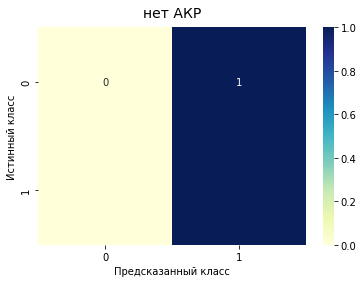

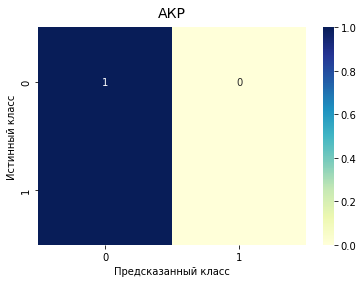

In [44]:
eval_metrics(y_pred, y_test)